# **MOVING AVERAGES (MA)**
- Due to the volatility of daily stock prices, moving averages are used to smooth price moves and identify the price trend

## Trading Strategies
1. **Buy (Mua):** When the short-term MA ($M$-day) crosses above the long-term MA ($N$-day).
(Khi đường MA ngắn hạn cắt lên trên đường MA dài hạn).
2. **Sell/Short (Bán):** When the short-term MA crosses below the long-term MA.(Khi đường MA ngắn hạn cắt xuống dưới đường MA dài hạn).
- **Goal:** It does not try to pick the market top or bottom. It waits until the trend is established to capture the middle part of a trend.

## DATA

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

### Downloading data

In [2]:
## Download raw data from yfinance
ticker = 'SPY'
print(f"Tải dữ liệu {ticker} từ yahoo finance.")
data = yf.download(ticker, start='2015-01-01', end='2025-10-01', progress=False, auto_adjust=False)
data.tail()

Tải dữ liệu SPY từ yahoo finance.


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
2025-09-24,661.099976,661.099976,664.609985,659.669983,664.510010,68082200
2025-09-25,658.049988,658.049988,659.409973,654.409973,657.940002,89622100
2025-09-26,661.820007,661.820007,662.369995,657.880005,659.510010,69179200
2025-09-29,663.679993,663.679993,665.280029,661.859985,664.359985,73499000
2025-09-30,666.179993,666.179993,666.650024,661.609985,662.929993,86288000


In [3]:
## Xử lý MultiIndex (Flatten Columns)
if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,171.093704,205.429993,206.880005,204.179993,206.380005,121465900
2015-01-05,168.003830,201.720001,204.369995,201.350006,204.169998,169632600
2015-01-06,166.421387,199.820007,202.720001,198.860001,202.089996,209151400
2015-01-07,168.495193,202.309998,202.720001,200.880005,201.419998,125346700
2015-01-08,171.485123,205.899994,206.160004,203.990005,204.009995,147217800


In [4]:
df = data.copy()

### Cleaning Data

In [5]:
## Loại bỏ dữ liệu phi logic (Logically Inconsistent)
# Rule A: Volume không được âm
mask_vol = df['Volume'] >= 0

# Rule B: High phải lớn hơn hoặc bằng Low
mask_hl = df['High'] >= df['Low']

# Rule C: Close và Open phải nằm trong khoảng High-Low (chấp nhận sai số nhỏ do làm tròn)
epsilon = 1e-4 # Sửa lỗi làm tròn số khi code
mask_rng_close = (df['Close'] <= df['High'] + epsilon) & (df['Close'] >= df['Low'] - epsilon)
mask_rng_open  = (df['Open']  <= df['High'] + epsilon) & (df['Open']  >= df['Low'] - epsilon)

# Tổng hợp các dòng HỢP LỆ
valid_rows = mask_vol & mask_hl & mask_rng_close & mask_rng_open

# Đếm số dòng lỗi
invalid_count = len(df) - valid_rows.sum()
if invalid_count > 0:
    print(f"Phát hiện {invalid_count} dòng lỗi logic (trên dữ liệu gốc)")
    # In thử 1 dòng lỗi để kiểm tra xem có phải lỗi thật không
    # print("Ví dụ dòng lỗi:", df[~valid_rows].head(1))
    print('Đã loại bỏ dữ liệu phi logic.')
    df = df[valid_rows]
else:
    print('Không tồn tại dữ liệu phi logic.')

Không tồn tại dữ liệu phi logic.


In [6]:
## Chuẩn hóa tên cột
df['close'] = df['Adj Close']
df = df.rename(columns={
        'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume'
    })

# Chỉ giữ các cột OHLCV
required_cols = ['open', 'high', 'low', 'close', 'volume']
df = df[required_cols]

df.tail()

Price,open,high,low,close,volume
Date,,,,,
2025-09-24,664.510010,664.609985,659.669983,661.099976,68082200
2025-09-25,657.940002,659.409973,654.409973,658.049988,89622100
2025-09-26,659.510010,662.369995,657.880005,661.820007,69179200
2025-09-29,664.359985,665.280029,661.859985,663.679993,73499000
2025-09-30,662.929993,666.650024,661.609985,666.179993,86288000


In [7]:
# Missing Values
## LOCF (Last Observation Carried Forward)
df = df.ffill()
## Delete NaN data
df = df.dropna()

In [8]:
# Kiểm tra biến động cực đoan (Fat Tails Check)
# Không xóa blindly các outlier, chỉ flag.
# In cảnh báo nếu giá biến động > 20% một ngày để kiểm tra. (Kiểm tra có thể do sáp nhập M&A, Earning Suprise hoặc Flash Crash - Sập giá)
daily_ret = df['close'].pct_change().abs()
extreme_moves = daily_ret[daily_ret > 0.20] # Biến động > 20%

if not extreme_moves.empty:
    print(f"\n Phát hiện {len(extreme_moves)} ngày biến động giá > 20%.")
    print(extreme_moves.tail(3)) # In ra 3 ngày gần nhất

In [9]:
# Kiểm tra Volume = 0 (Thanh khoản kém)
# Thanh khoản thấp (Low Liquidity)
zero_vol_count = (df['volume'] == 0).sum()
if zero_vol_count > 0:
    print(f"Lưu ý: Có {zero_vol_count} ngày không có giao dịch (Volume=0).")
    # Với SMA nên giữ lại không xóa để tránh gãy chuỗi.

### Plotting

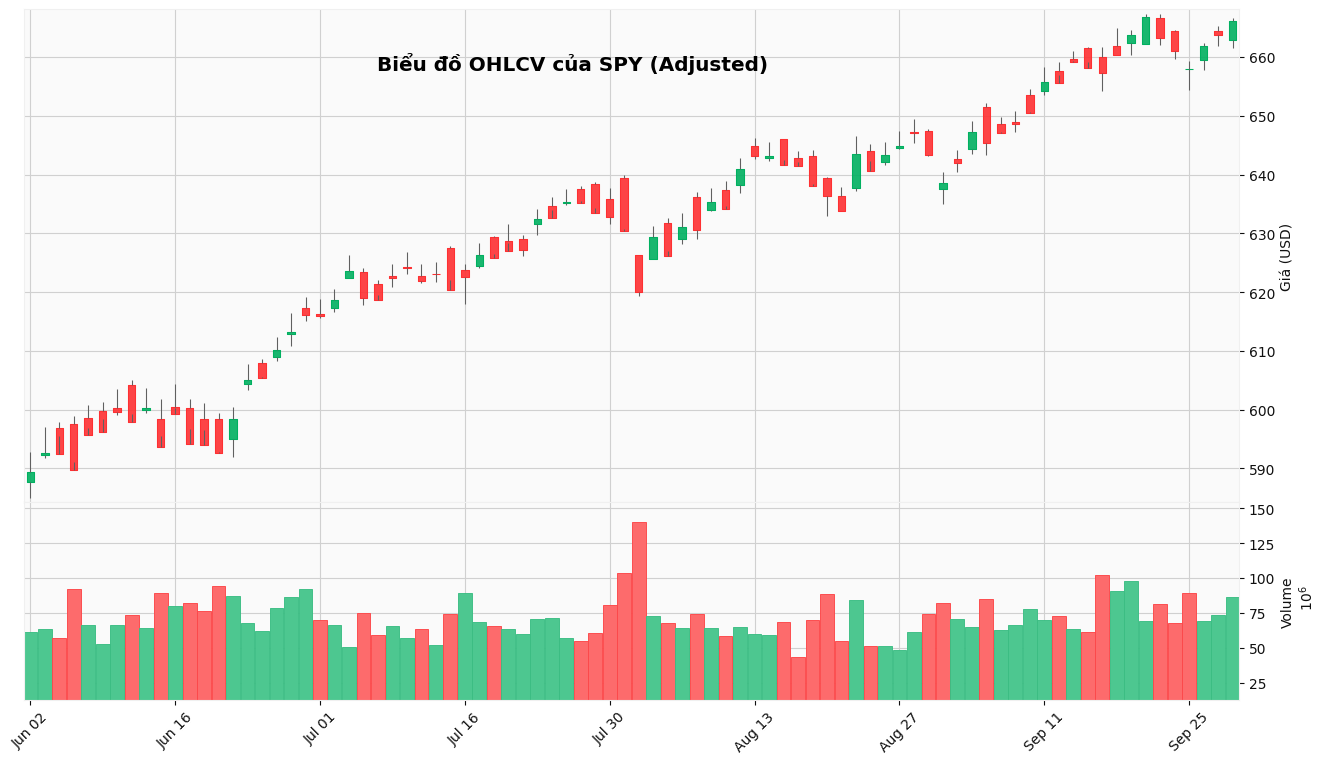

In [10]:
# Thiết lập giao diện (Style)
# 'yahoo': Phong cách giống Yahoo Finance (Nến xanh/đỏ)
my_style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 10})

# Vẽ biểu đồ
# type='candle': Biểu đồ nến
# volume=True: Hiển thị Volume bên dưới
df_short = df.loc['2025-06-01':'2025-10-01']
mpf.plot(df_short,
         type='candle',
         style=my_style,
         title=f'Biểu đồ OHLCV của {ticker} (Adjusted)',
         ylabel='Giá (USD)',
         ylabel_lower='Volume',
         volume=True,
         figsize=(14, 8),
         tight_layout=True)


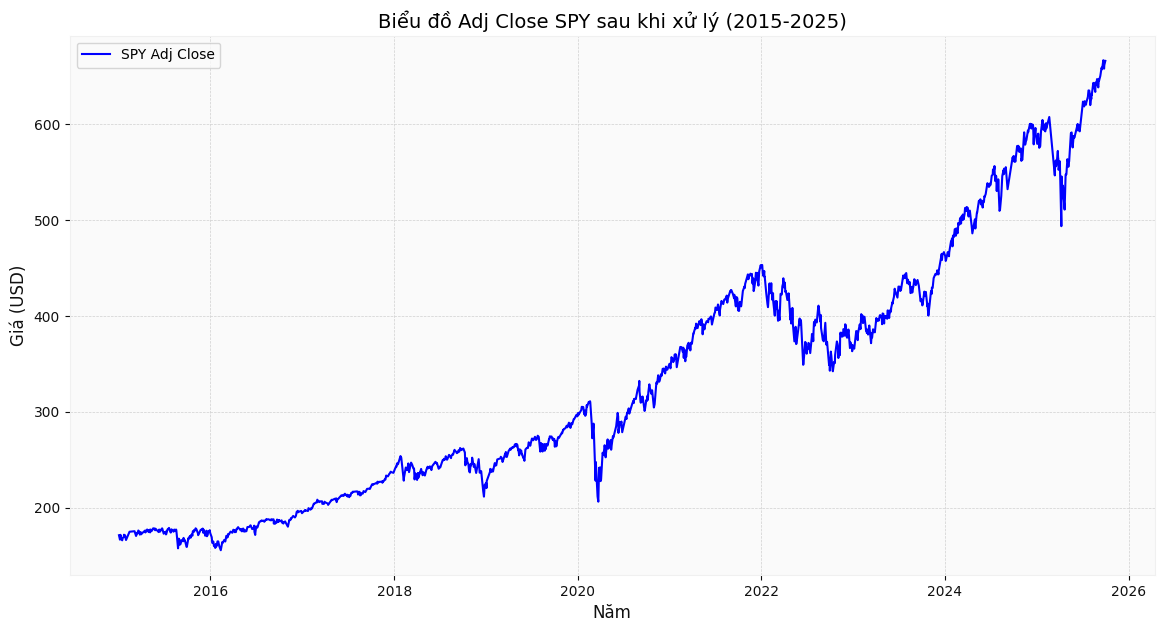

In [11]:
# Vẽ biểu đồ thể hiện Adj Close
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label=f'{ticker} Adj Close', color='blue', linewidth=1.5)

plt.title(f'Biểu đồ Adj Close {ticker} sau khi xử lý (2015-2025)', fontsize=14)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

## SMA (Simple Moving Average)
- The N-day SMA is the average close price of the past N days.
- Formula: $SMA_{N} = \frac{1}{N} \sum_{i=0}^{N-1} C_{t-i}$
- **Drawback:** It treats all prices of the past N days equally, failing to give more weight to recent data.

Trading Signal
- Tín hiệu MUA (Long Entry): Khi đường SMA 50 (Ngắn hạn) cắt lên trên đường SMA 200 (Dài hạn). Đây gọi là "Golden Cross", báo hiệu thị trường bước vào xu hướng tăng dài hạn.
- Tín hiệu BÁN/THOÁT (Exit/Short): Khi đường SMA 50 cắt xuống dưới đường SMA 200. Đây gọi là "Death Cross", báo hiệu xu hướng giảm.

In [12]:
def strategy_sma_crossover(data_input):
    df_sma = data_input.copy()

    # 1. Tính toán SMA50 và SMA200
    df_sma['SMA_50'] = df_sma['close'].rolling(window=50).mean()
    df_sma['SMA_200'] = df_sma['close'].rolling(window=200).mean()

    # 2. Tạo Tín hiệu (Signal)
    # Signal = 1 khi SMA_50 > SMA_200 (Giữ cổ phiếu - Mua cổ phiếu)
    # Signal = 0 khi SMA_50 <= SMA_200 (Giữ tiền mặt - Bán hết cổ phiếu)
    df_sma['Signal'] = 0
    df_sma.loc[df_sma['SMA_50'] > df_sma['SMA_200'], 'Signal'] = 1

    # 3. Tính Lợi nhuận Chiến lược (Strategy Returns)
    # Market Return: Lợi nhuận hàng ngày của cổ phiếu
    df_sma['Market_Return'] = df_sma['close'].pct_change()

    # Strategy Return: Lợi nhuận khi theo tín hiệu
    # shift(1) là quan trọng: Tín hiệu hôm nay dùng để giao dịch cho ngày mai (tránh look-ahead bias)
    df_sma['Strategy_Return'] = df_sma['Signal'].shift(1) * df_sma['Market_Return']

    # 4. Tính Lợi nhuận tích lũy (Cumulative Returns) - Lãi kép
    df_sma['Cumulative_Market'] = (1 + df_sma['Market_Return']).cumprod()
    df_sma['Cumulative_Strategy'] = (1 + df_sma['Strategy_Return']).cumprod()

    return df_sma

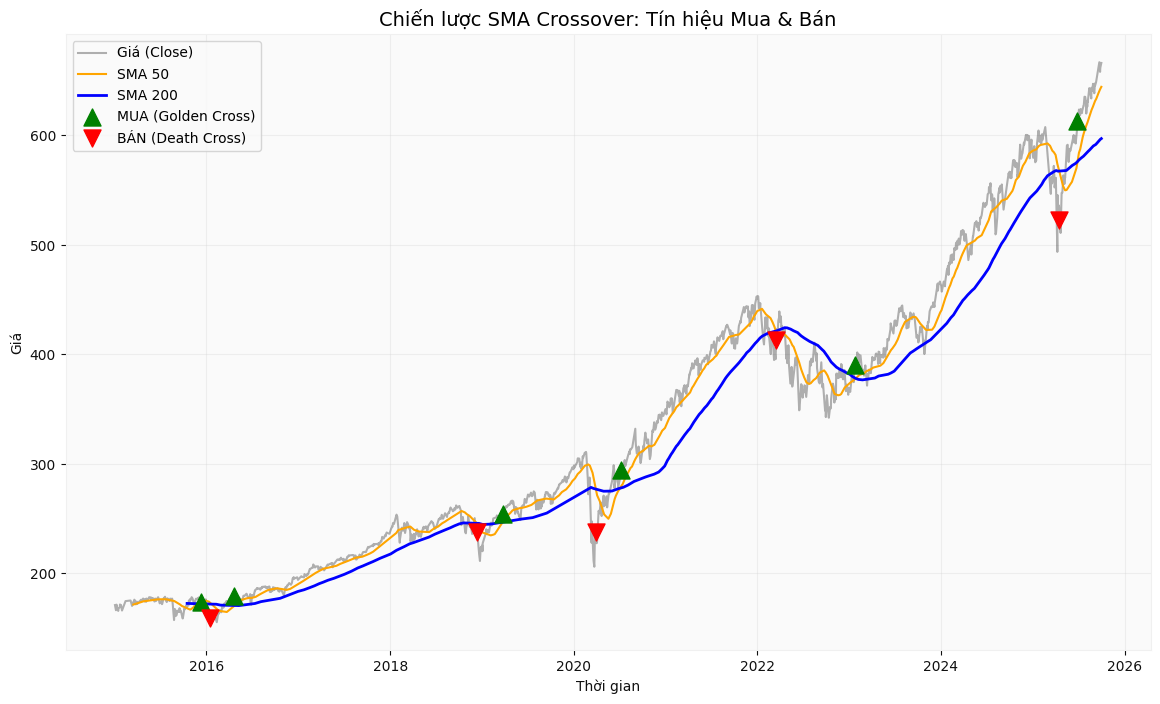

In [13]:
# --- PLOT SIGNAL TRADING ---

results = strategy_sma_crossover(df)

# Xác định điểm Mua và Bán
# Dùng hàm .diff() để tìm sự thay đổi của Signal
# diff = 1: Signal chuyển từ 0 lên 1 (MUA - Golden Cross)
# diff = -1: Signal chuyển từ 1 xuống 0 (BÁN - Death Cross)
results['Position_Change'] = results['Signal'].diff()

# Lọc ra các dòng có lệnh Mua/Bán
buy_signals = results[results['Position_Change'] == 1]
sell_signals = results[results['Position_Change'] == -1]

# 3. Vẽ biểu đồ
plt.figure(figsize=(14, 8))


plt.plot(results.index, results['close'], label='Giá (Close)', color='black', alpha=0.3)
# Vẽ SMA 50 (Ngắn hạn - Màu cam)
plt.plot(results.index, results['SMA_50'], label='SMA 50', color='orange', linewidth=1.5)
# Vẽ SMA 200 (Dài hạn - Màu xanh dương)
plt.plot(results.index, results['SMA_200'], label='SMA 200', color='blue', linewidth=2)


plt.scatter(buy_signals.index, buy_signals['close'],
            marker='^', color='green', s=150, zorder=5, label='MUA (Golden Cross)')
plt.scatter(sell_signals.index, sell_signals['close'],
            marker='v', color='red', s=150, zorder=5, label='BÁN (Death Cross)')

plt.title('Chiến lược SMA Crossover: Tín hiệu Mua & Bán', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.show()

### Backtest

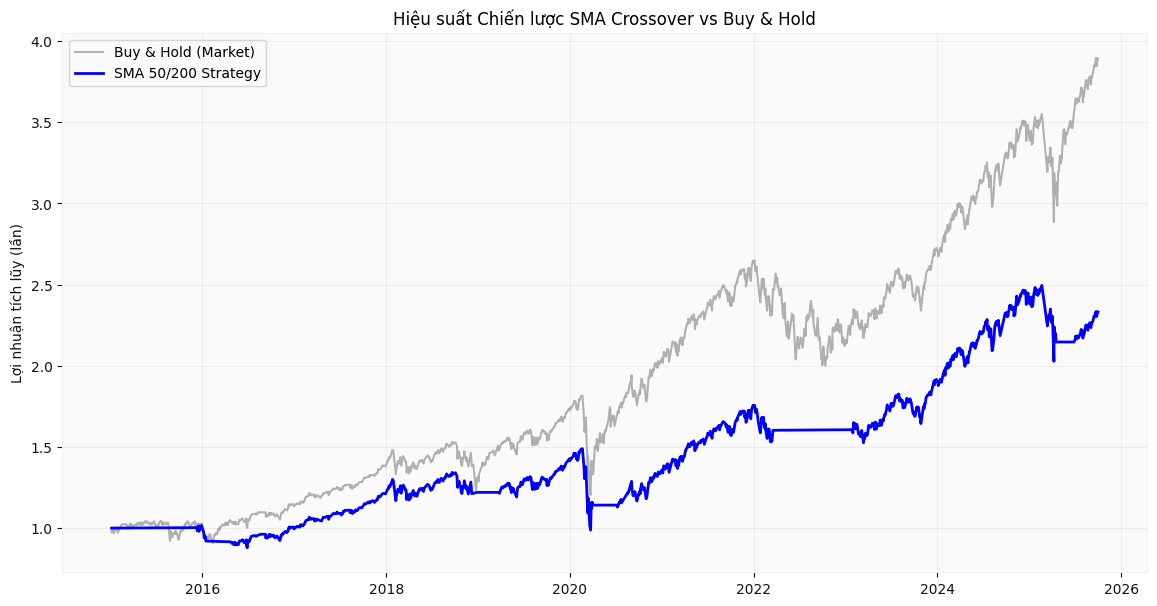

Lợi nhuận Buy & Hold: 289.37%
Lợi nhuận Chiến lược SMA: 133.18%


In [14]:
results = strategy_sma_crossover(df)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Cumulative_Market'], label='Buy & Hold (Market)', color='gray', alpha=0.6)
plt.plot(results.index, results['Cumulative_Strategy'], label='SMA 50/200 Strategy', color='blue', linewidth=2)

plt.title('Hiệu suất Chiến lược SMA Crossover vs Buy & Hold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Lợi nhuận tích lũy (lần)')
plt.show()

# In thống kê cuối cùng
total_ret_market = results['Cumulative_Market'].iloc[-1] - 1
total_ret_strategy = results['Cumulative_Strategy'].iloc[-1] - 1
print(f"Lợi nhuận Buy & Hold: {total_ret_market:.2%}")
print(f"Lợi nhuận Chiến lược SMA: {total_ret_strategy:.2%}")

Tại sao Chiến lược chỉ sử dụng SMA không hiệu quả?
- Độ trễ (The Cost of Lag): Khi thị trường đảo chiều tăng mạnh, SMA phản ứng chậm. Bắt đầu mua khi giá đã tăng một đoạn khá xa, bỏ lỡ đoạn lợi nhuận từ đáy.
- Tín hiệu giả (Whipsaws in Sideways Markets): Khi thị trường đi ngang (không rõ xu hướng), giá cứ cắt lên rồi lại cắt xuống liên tục. Bị "mua đỉnh bán đáy" liên tiếp (mua xong giá giảm, bán xong giá tăng), khiến tài khoản bị bào mòn dần bởi các khoản lỗ nhỏ.

Cách khắc khục:
- Chuyển sang EMA (Exponential Moving Average) là bước nâng cấp đầu tiên để khắc phục nhược điểm "trọng số bình đẳng" (equal weighting) của SMA.
- Lý thuyết: EMA gán trọng số lớn hơn cho dữ liệu giá gần nhất, giúp đường trung bình phản ứng nhanh hơn với sự thay đổi của thị trường và giảm bớt độ trễ (lag)
- Formula: $$EMA_{t} = \alpha \times P_{t} + (1 - \alpha) \times EMA_{t-1}$$ với $$\alpha = \frac{2}{N + 1}$$

## EMA (Exponential Moving Average)

In [15]:
def strategy_ema(df):
    """
    Chiến lược: MUA khi EMA ngắn hạn cắt lên EMA dài hạn.
    BÁN (Giữ tiền) khi EMA ngắn hạn cắt xuống.
    """
    df_ema = df.copy()

    # --- Tính Chỉ báo EMA ---
    # Dùng ewm (Exponential Weighted Functions) để tính EMA
    # adjust=False giúp tính đệ quy: EMA_t = alpha * Price + (1-alpha) * EMA_t-1
    df_ema['EMA_50'] = df_ema['close'].ewm(span=50, adjust=False).mean()
    df_ema['EMA_200'] = df_ema['close'].ewm(span=200, adjust=False).mean()

    # --- Tạo Tín hiệu (Signal) ---
    df_ema['Signal'] = 0
    # Điều kiện MUA: EMA Ngắn > EMA Dài
    df_ema.loc[df_ema['EMA_50'] > df_ema['EMA_200'], 'Signal'] = 1

    # Xác định điểm Mua/Bán để vẽ lên biểu đồ (diff: 1=Mua, -1=Bán)
    df_ema['Order'] = df_ema['Signal'].diff()

    # --- Tính Lợi nhuận ---
    # Lợi nhuận thị trường (Buy & Hold)
    df_ema['Market_Return'] = df_ema['close'].pct_change()

    # Lợi nhuận Chiến lược (Dùng tín hiệu hôm qua để giao dịch hôm nay -> shift(1))
    df_ema['Strategy_Return'] = df_ema['Signal'].shift(1) * df_ema['Market_Return']

    # Tính giá trị tài sản tích lũy (Bắt đầu từ 1 đồng)
    df_ema['Cumulative_Market'] = (1 + df_ema['Market_Return'].fillna(0)).cumprod()
    df_ema['Cumulative_Strategy'] = (1 + df_ema['Strategy_Return'].fillna(0)).cumprod()

    return df_ema

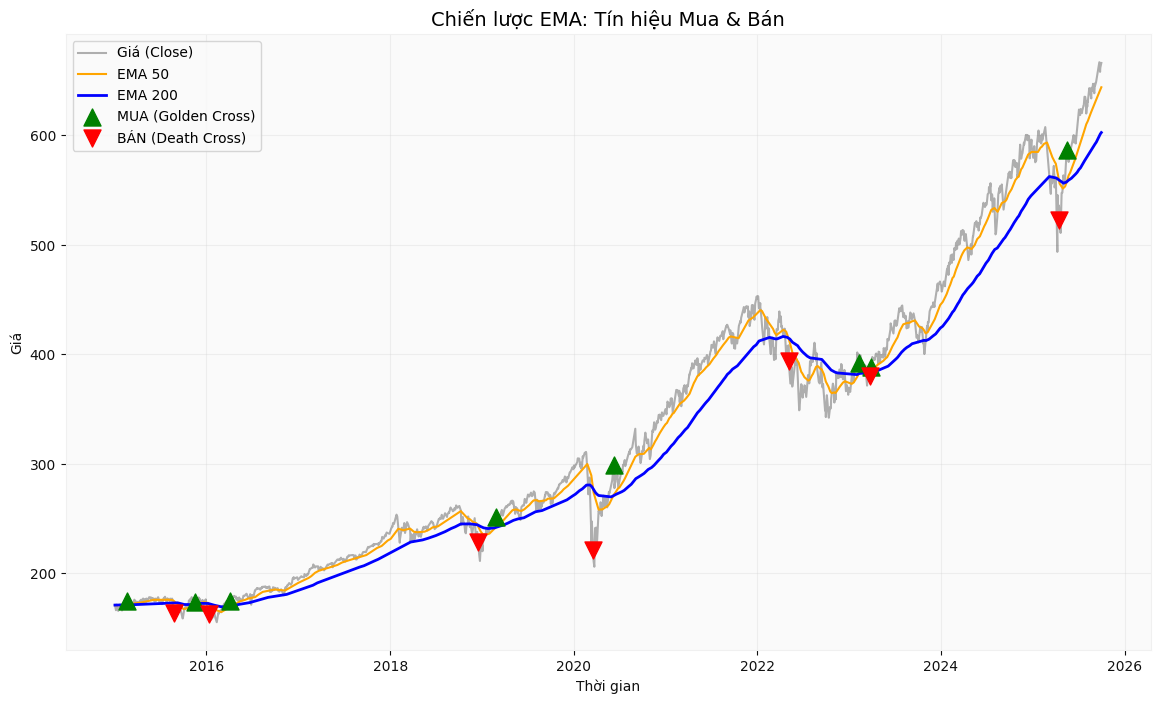

In [16]:
# --- PLOT SIGNAL TRADING ---

results2 = strategy_ema(df)

# Xác định điểm Mua và Bán
# Dùng hàm .diff() để tìm sự thay đổi của Signal
# diff = 1: Signal chuyển từ 0 lên 1 (MUA - Golden Cross)
# diff = -1: Signal chuyển từ 1 xuống 0 (BÁN - Death Cross)
results2['Position_Change'] = results2['Signal'].diff()

# Lọc ra các dòng có lệnh Mua/Bán
buy_signals2 = results2[results2['Position_Change'] == 1]
sell_signals2 = results2[results2['Position_Change'] == -1]

# 3. Vẽ biểu đồ
plt.figure(figsize=(14, 8))


plt.plot(results2.index, results2['close'], label='Giá (Close)', color='black', alpha=0.3)
# Vẽ SMA 50 (Ngắn hạn - Màu cam)
plt.plot(results2.index, results2['EMA_50'], label='EMA 50', color='orange', linewidth=1.5)
# Vẽ SMA 200 (Dài hạn - Màu xanh dương)
plt.plot(results2.index, results2['EMA_200'], label='EMA 200', color='blue', linewidth=2)


plt.scatter(buy_signals2.index, buy_signals2['close'],
            marker='^', color='green', s=150, zorder=5, label='MUA (Golden Cross)')
plt.scatter(sell_signals2.index, sell_signals2['close'],
            marker='v', color='red', s=150, zorder=5, label='BÁN (Death Cross)')

plt.title('Chiến lược EMA: Tín hiệu Mua & Bán', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.show()

### Backtest

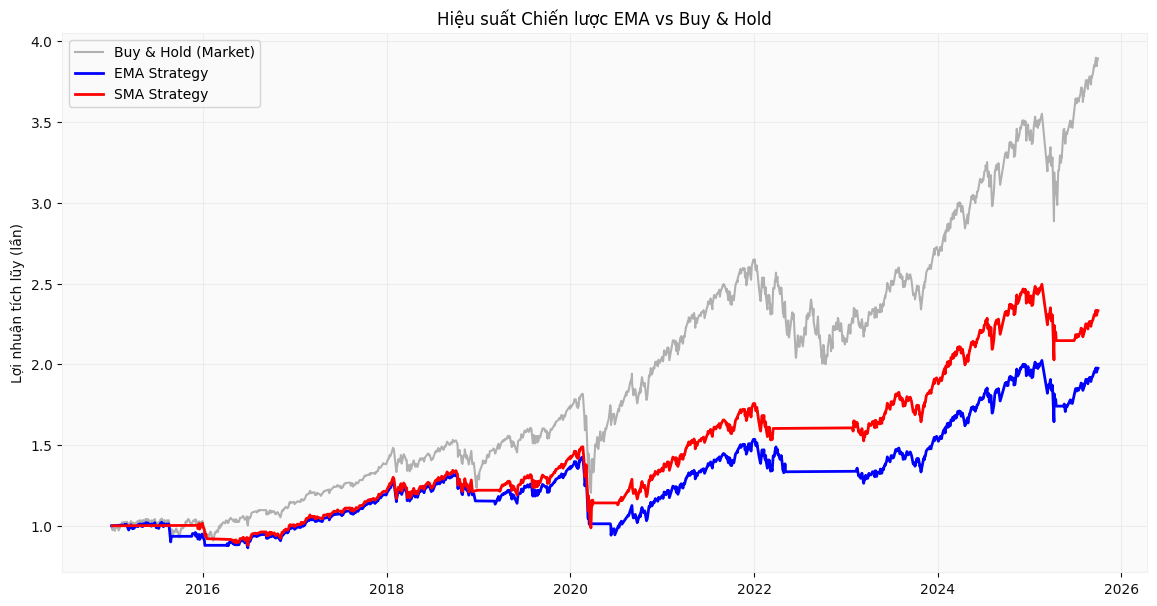

Lợi nhuận Buy & Hold: 289.37%
Lợi nhuận Chiến lược EMA: 97.53%
Lợi nhuận Chiến lược SMA: 133.18%


In [17]:
results = strategy_ema(df)
results2 = strategy_sma_crossover(df)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Cumulative_Market'], label='Buy & Hold (Market)', color='gray', alpha=0.6)
plt.plot(results.index, results['Cumulative_Strategy'], label='EMA Strategy', color='blue', linewidth=2)
plt.plot(results.index, results2['Cumulative_Strategy'], label='SMA Strategy', color='red', linewidth=2)

plt.title('Hiệu suất Chiến lược EMA vs Buy & Hold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Lợi nhuận tích lũy (lần)')
plt.show()

# In thống kê cuối cùng
total_ret_market = results['Cumulative_Market'].iloc[-1] - 1
total_ret_strategy = results['Cumulative_Strategy'].iloc[-1] - 1
total_ret_strategy2 = results2['Cumulative_Strategy'].iloc[-1] - 1
print(f"Lợi nhuận Buy & Hold: {total_ret_market:.2%}")
print(f"Lợi nhuận Chiến lược EMA: {total_ret_strategy:.2%}")
print(f"Lợi nhuận Chiến lược SMA: {total_ret_strategy2:.2%}")

Nếu xét về khả năng bảo vệ vốn khi thị trường sập (Bear Market) thì sao? Ta đi tính Max Drawdown để thấy rõ biểu hiện.

Max Drawdown (MDD) đo lường mức giảm phần trăm lớn nhất từ một đỉnh (Peak) xuống một đáy (Trough) xảy ra sau đó, trước khi một đỉnh mới được thiết lập.$$MDD = \min_{t \in (0, T)} \left( \frac{V_t - P_t}{P_t} \right)$$
Trong đó:
- $V_t$: Giá trị tài sản (Portfolio Value) tại thời điểm $t$.
- $P_t$: Giá trị đỉnh cao nhất đạt được trước thời điểm $t$ (Running Maximum).
$$P_t = \max_{\tau \in (0, t)} V_\tau$$

Chiến lược      | Max Drawdown (Rủi ro) | Lợi nhuận      
-------------------------------------------------------
Buy & Hold      | -33.72%                | 289.37%
SMA Strategy    | -33.72%                | 133.18%
EMA Strategy    | -33.88%                | 97.53%


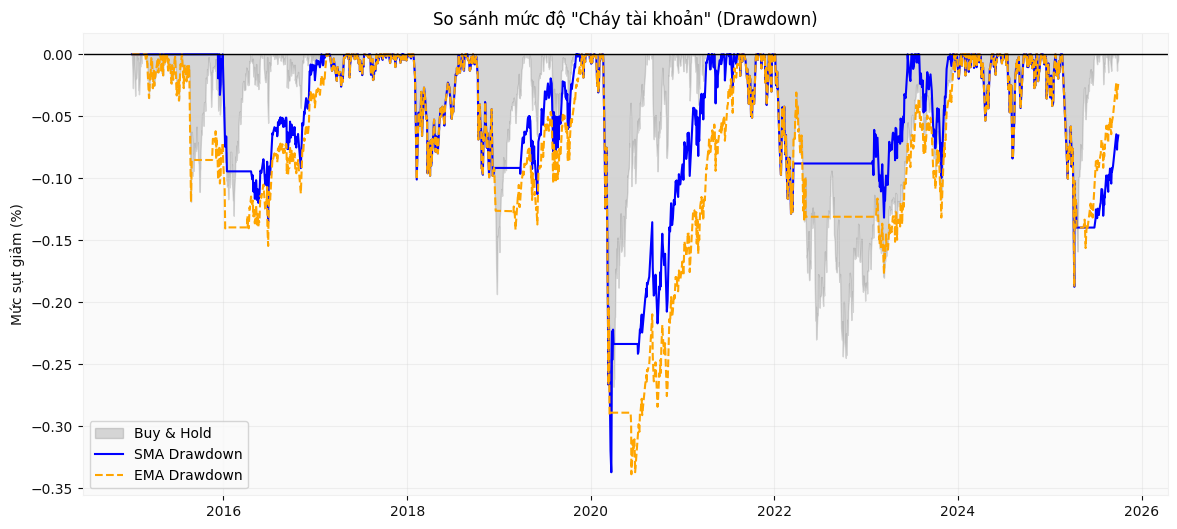

In [18]:

SHORT = 50
LONG = 200

# 1. Tính toán Chiến lược (SMA & EMA)
data = df.copy()
data['Ret'] = data['close'].pct_change() # Lợi nhuận hàng ngày của thị trường

# --- Chiến lược SMA ---
data['SMA_S'] = data['close'].rolling(window=SHORT).mean()
data['SMA_L'] = data['close'].rolling(window=LONG).mean()
data['Sig_SMA'] = np.where(data['SMA_S'] > data['SMA_L'], 1, 0)
data['Ret_SMA'] = data['Sig_SMA'].shift(1) * data['Ret'] # Lợi nhuận SMA

# --- Chiến lược EMA ---
data['EMA_S'] = data['close'].ewm(span=SHORT, adjust=False).mean()
data['EMA_L'] = data['close'].ewm(span=LONG, adjust=False).mean()
data['Sig_EMA'] = np.where(data['EMA_S'] > data['EMA_L'], 1, 0)
data['Ret_EMA'] = data['Sig_EMA'].shift(1) * data['Ret'] # Lợi nhuận EMA

# 2. Tính Tích lũy (Cumulative Return)
# Buy & Hold (Market)
data['Cum_Mkt'] = (1 + data['Ret'].fillna(0)).cumprod()
data['Cum_SMA'] = (1 + data['Ret_SMA'].fillna(0)).cumprod()
data['Cum_EMA'] = (1 + data['Ret_EMA'].fillna(0)).cumprod()

# 3. Tính Drawdown (Vùng sụt giảm)
def calc_dd(series):
    peak = series.cummax()
    return (series - peak) / peak

data['DD_Mkt'] = calc_dd(data['Cum_Mkt'])
data['DD_SMA'] = calc_dd(data['Cum_SMA'])
data['DD_EMA'] = calc_dd(data['Cum_EMA'])

# 4. In Kết quả So sánh
mdd_mkt = data['DD_Mkt'].min()
mdd_sma = data['DD_SMA'].min()
mdd_ema = data['DD_EMA'].min()

print(f"{'Chiến lược':<15} | {'Max Drawdown (Rủi ro)':<20} | {'Lợi nhuận':<15}")
print("-" * 55)
print(f"{'Buy & Hold':<15} | {mdd_mkt:.2%}                | {data['Cum_Mkt'].iloc[-1]-1:.2%}")
print(f"{'SMA Strategy':<15} | {mdd_sma:.2%}                | {data['Cum_SMA'].iloc[-1]-1:.2%}")
print(f"{'EMA Strategy':<15} | {mdd_ema:.2%}                | {data['Cum_EMA'].iloc[-1]-1:.2%}")

# 5. Vẽ Biểu đồ "Underwater" (So sánh độ sâu khi sập)
plt.figure(figsize=(14, 6))
plt.fill_between(data.index, data['DD_Mkt'], 0, color='gray', alpha=0.3, label='Buy & Hold')
plt.plot(data.index, data['DD_SMA'], color='blue', linewidth=1.5, label='SMA Drawdown')
plt.plot(data.index, data['DD_EMA'], color='orange', linewidth=1.5, linestyle='--', label='EMA Drawdown')

plt.title('So sánh mức độ "Cháy tài khoản" (Drawdown)')
plt.ylabel('Mức sụt giảm (%)')
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## DEMA (Double exponential moving average)
DEMA là một công thức toán học thông minh để cộng thêm vận tốc vào đường trung bình, giúp nó bắt kịp giá hiện tại (zero lag).
Formula:$$DEMA = 2 \times EMA_N - EMA(EMA_N)$$
Trong đó:
- $EMA_N$: Là đường EMA cấp 1 của giá (EMA thông thường).
- $EMA(EMA_N)$: Là đường EMA cấp 2 (Lấy đường EMA cấp 1 làm đầu vào để tính EMA tiếp lần nữa).
- $2 \times EMA_1 - EMA_2$: $EMA_2$ trễ hơn $EMA_1$.
- Hiệu số $(EMA_1 - EMA_2)$ đại diện cho "lỗi do độ trễ" (Lag error).
- Ta lấy $EMA_1$ cộng thêm phần lỗi này vào chính nó để "đẩy" đường chỉ báo về phía trước: $EMA_1 + (EMA_1 - EMA_2) = 2EMA_1 - EMA_2$.

In [26]:

def calculate_dema(series, span):

    # Tính EMA cấp 1
    ema1 = series.ewm(span=span, adjust=False).mean()
    # Tính EMA cấp 2 (EMA của EMA1)
    ema2 = ema1.ewm(span=span, adjust=False).mean()

    # Công thức khử trễ
    dema = 2 * ema1 - ema2
    return dema


def strategy_dema(df):
    data = df.copy()

    # --- A. TÍNH CHỈ BÁO ---
    # 1. Tính DEMA (Chiến lược chính)
    data['DEMA_50'] = calculate_dema(data['close'], span=50)
    data['DEMA_200'] = calculate_dema(data['close'], span=200)

    # --- B. TẠO TÍN HIỆU  ---
    data['Signal'] = 0
    # Mua khi DEMA Ngắn cắt lên DEMA Dài
    data.loc[data['DEMA_50'] > data['DEMA_200'], 'Signal'] = 1

    # --- C. TÍNH HIỆU SUẤT ---
    data['Market_Ret'] = data['close'].pct_change()
    data['Strategy_Ret'] = data['Signal'].shift(1) * data['Market_Ret']

    data['Cumulative_Market'] = (1 + data['Market_Ret'].fillna(0)).cumprod()
    data['Cumulative_Strategy'] = (1 + data['Strategy_Ret'].fillna(0)).cumprod()

    # Tính Drawdown
    peak = data['Cumulative_Strategy'].cummax()
    data['Drawdown'] = (data['Cumulative_Strategy'] - peak) / peak

    return data

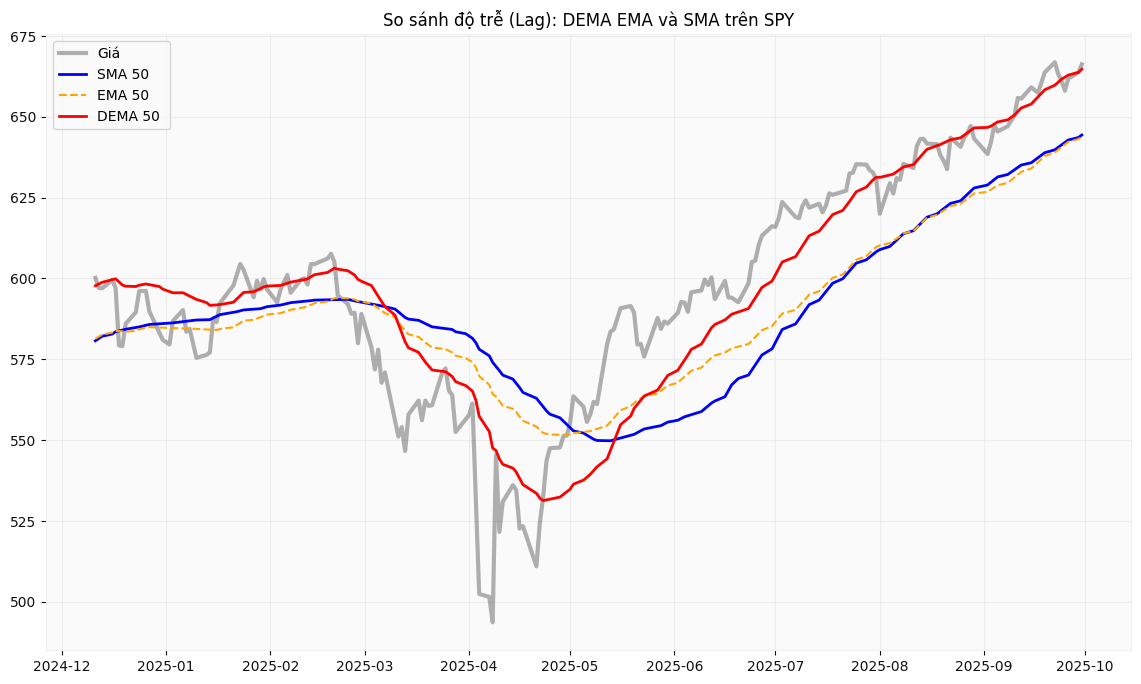

In [27]:
# --- VẼ BIỂU ĐỒ SO SÁNH ĐỘ TRỄ ---

results3 = strategy_sma_crossover(df)
results2 = strategy_ema(df)
results = strategy_dema(df)

subset = results.tail(200)
subset2 = results2.tail(200)
subset3 = results3.tail(200)
plt.figure(figsize=(14, 8))

# 1. Giá
plt.plot(subset.index, subset['close'], color='black', alpha=0.3, label='Giá', linewidth=3)

# 2. So sánh Short MA (50 ngày)
plt.plot(subset3.index, subset3['SMA_50'], color='blue', linewidth=2, label='SMA 50 ')
plt.plot(subset2.index, subset2['EMA_50'], color='orange', linestyle='--', label='EMA 50 ')
plt.plot(subset.index, subset['DEMA_50'], color='red', linewidth=2, label='DEMA 50 ')

plt.title(f'So sánh độ trễ (Lag): DEMA EMA và SMA trên {ticker}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


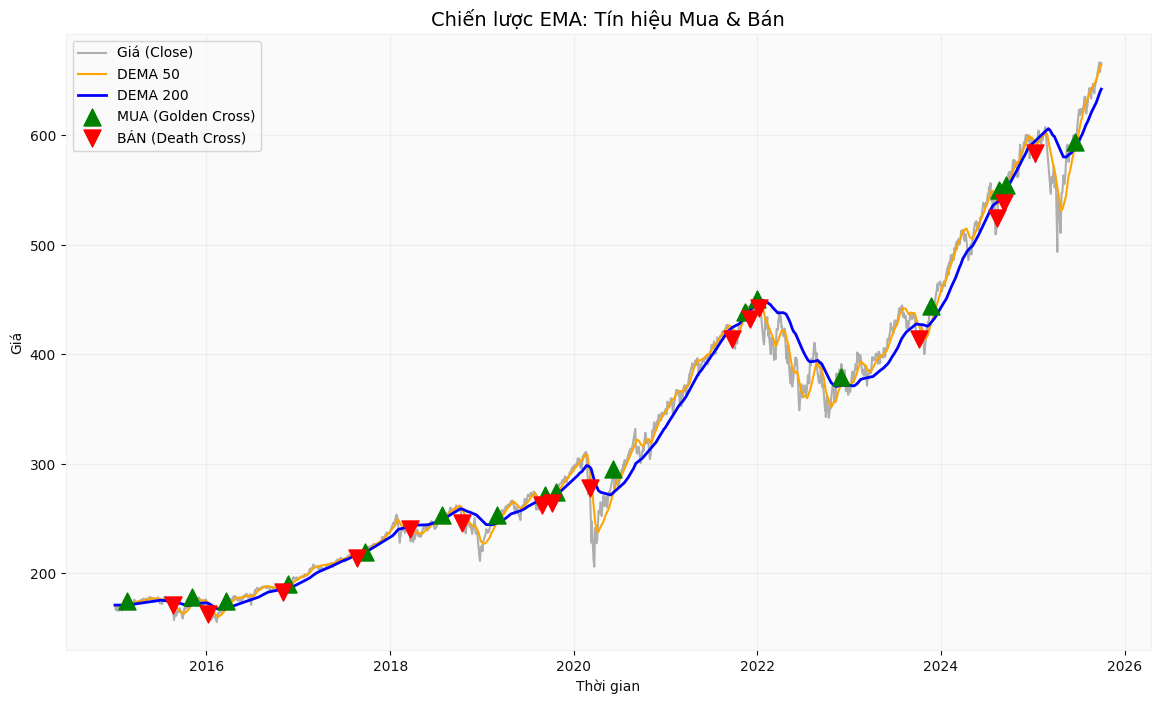

In [28]:
# --- PLOT SIGNAL TRADING ---

results = strategy_dema(df)

# Xác định điểm Mua và Bán
# Dùng hàm .diff() để tìm sự thay đổi của Signal
# diff = 1: Signal chuyển từ 0 lên 1 (MUA - Golden Cross)
# diff = -1: Signal chuyển từ 1 xuống 0 (BÁN - Death Cross)
results['Position_Change'] = results['Signal'].diff()

# Lọc ra các dòng có lệnh Mua/Bán
buy_signals = results[results['Position_Change'] == 1]
sell_signals = results[results['Position_Change'] == -1]

# 3. Vẽ biểu đồ
plt.figure(figsize=(14, 8))


plt.plot(results.index, results['close'], label='Giá (Close)', color='black', alpha=0.3)
# Vẽ SMA 50 (Ngắn hạn - Màu cam)
plt.plot(results.index, results['DEMA_50'], label='DEMA 50', color='orange', linewidth=1.5)
# Vẽ SMA 200 (Dài hạn - Màu xanh dương)
plt.plot(results.index, results['DEMA_200'], label='DEMA 200', color='blue', linewidth=2)


plt.scatter(buy_signals.index, buy_signals['close'],
            marker='^', color='green', s=150, zorder=5, label='MUA (Golden Cross)')
plt.scatter(sell_signals.index, sell_signals['close'],
            marker='v', color='red', s=150, zorder=5, label='BÁN (Death Cross)')

plt.title('Chiến lược EMA: Tín hiệu Mua & Bán', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.show()

### Backtest

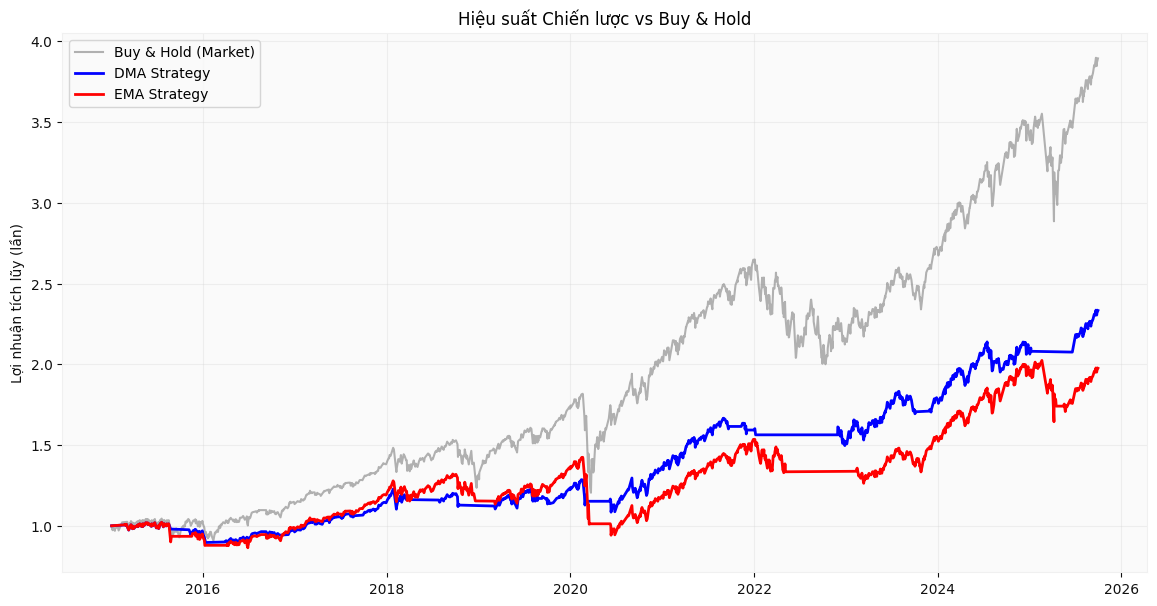

Lợi nhuận Buy & Hold: 289.37%
Lợi nhuận Chiến lược DMA: 133.29%
Lợi nhuận Chiến lược EMA: 97.53%


In [29]:
results = strategy_dema(df)
results2 = strategy_ema(df)


# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
plt.plot(results.index, results2['Cumulative_Market'], label='Buy & Hold (Market)', color='gray', alpha=0.6)
plt.plot(results.index, results['Cumulative_Strategy'], label='DMA Strategy', color='blue', linewidth=2)
plt.plot(results.index, results2['Cumulative_Strategy'], label='EMA Strategy', color='red', linewidth=2)

plt.title('Hiệu suất Chiến lược vs Buy & Hold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Lợi nhuận tích lũy (lần)')
plt.show()

# In thống kê cuối cùng
total_ret_market = results['Cumulative_Market'].iloc[-1] - 1
total_ret_strategy = results['Cumulative_Strategy'].iloc[-1] - 1
total_ret_strategy2 = results2['Cumulative_Strategy'].iloc[-1] - 1
print(f"Lợi nhuận Buy & Hold: {total_ret_market:.2%}")
print(f"Lợi nhuận Chiến lược DMA: {total_ret_strategy:.2%}")
print(f"Lợi nhuận Chiến lược EMA: {total_ret_strategy2:.2%}")

Vì bám quá sát, DEMA cực kỳ nhạy cảm với mọi rung lắc nhỏ của thị trường.
Hậu quả: Khi thị trường Đi ngang (Sideways) hoặc không rõ xu hướng, giá cứ lên xuống nhẹ là DEMA đã cắt nhau loạn xạ.Do đó sẽ tạo ra nhiều tín hiệu giả (whipsaw): Mua xong giá giảm, Bán xong giá tăng. Tài khoản bị bào mòn bởi phí giao dịch và các khoản lỗ nhỏ liên tiếp. Thế nên cần biết thời điểm nào hợp lý để chiến lược được thực thi.

Chiến lược           | Max Drawdown (Rủi ro)     | Lợi nhuận cuối 
-----------------------------------------------------------------
Buy & Hold           | -33.72% (Thị trường)      | 289.37%
EMA Strategy         | -33.88% (Trễ hơn)         | 97.53%
DEMA Strategy        | -15.85% (Nhạy hơn)        | 133.29%


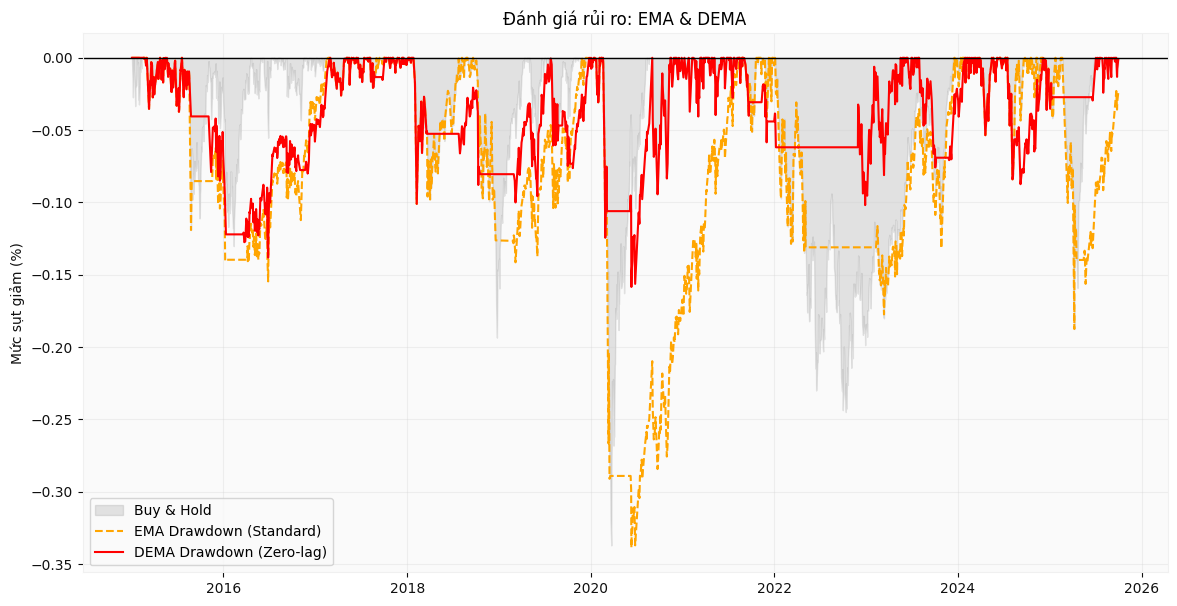

In [31]:

SHORT = 50
LONG = 200

# Hàm phụ trợ tính DEMA
def get_dema(series, span):
    ema1 = series.ewm(span=span, adjust=False).mean()
    ema2 = ema1.ewm(span=span, adjust=False).mean()
    return 2 * ema1 - ema2

# 1. Tính toán Chiến lược
data = df.copy()
data['Ret'] = data['close'].pct_change() # Lợi nhuận thị trường

# --- Chiến lược EMA (Tiêu chuẩn) ---
data['EMA_S'] = data['close'].ewm(span=SHORT, adjust=False).mean()
data['EMA_L'] = data['close'].ewm(span=LONG, adjust=False).mean()
data['Sig_EMA'] = np.where(data['EMA_S'] > data['EMA_L'], 1, 0)
data['Ret_EMA'] = data['Sig_EMA'].shift(1) * data['Ret']

# --- Chiến lược DEMA (Zero-lag) ---
data['DEMA_S'] = get_dema(data['close'], span=SHORT)
data['DEMA_L'] = get_dema(data['close'], span=LONG)
data['Sig_DEMA'] = np.where(data['DEMA_S'] > data['DEMA_L'], 1, 0)
data['Ret_DEMA'] = data['Sig_DEMA'].shift(1) * data['Ret']

# 2. Tính Tích lũy & Drawdown
# Buy & Hold (để làm nền tham chiếu)
data['Cum_Mkt'] = (1 + data['Ret'].fillna(0)).cumprod()
data['Cum_EMA'] = (1 + data['Ret_EMA'].fillna(0)).cumprod()
data['Cum_DEMA'] = (1 + data['Ret_DEMA'].fillna(0)).cumprod()

def calc_dd(series):
    peak = series.cummax()
    return (series - peak) / peak

data['DD_Mkt'] = calc_dd(data['Cum_Mkt'])
data['DD_EMA'] = calc_dd(data['Cum_EMA'])
data['DD_DEMA'] = calc_dd(data['Cum_DEMA'])

# 3. In Kết quả So sánh
mdd_mkt = data['DD_Mkt'].min()
mdd_ema = data['DD_EMA'].min()
mdd_dema = data['DD_DEMA'].min()

print(f"{'Chiến lược':<20} | {'Max Drawdown (Rủi ro)':<25} | {'Lợi nhuận cuối':<15}")
print("-" * 65)
print(f"{'Buy & Hold':<20} | {mdd_mkt:.2%} (Thị trường)      | {data['Cum_Mkt'].iloc[-1]-1:.2%}")
print(f"{'EMA Strategy':<20} | {mdd_ema:.2%} (Trễ hơn)         | {data['Cum_EMA'].iloc[-1]-1:.2%}")
print(f"{'DEMA Strategy':<20} | {mdd_dema:.2%} (Nhạy hơn)        | {data['Cum_DEMA'].iloc[-1]-1:.2%}")

# 4. Vẽ Biểu đồ "Underwater" (So sánh độ sâu khi sập)
plt.figure(figsize=(14, 7))

# Vẽ nền Buy & Hold mờ để tham chiếu
plt.fill_between(data.index, data['DD_Mkt'], 0, color='gray', alpha=0.2, label='Buy & Hold')

# So sánh EMA và DEMA
plt.plot(data.index, data['DD_EMA'], color='orange', linewidth=1.5, linestyle='--', label='EMA Drawdown (Standard)')
plt.plot(data.index, data['DD_DEMA'], color='red', linewidth=1.5, label='DEMA Drawdown (Zero-lag)')

plt.title('Đánh giá rủi ro: EMA & DEMA')
plt.ylabel('Mức sụt giảm (%)')
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

- Chiến lược Trend Following (như DEMA, EMA, SMA) có một điểm yếu cố hữu: Thoát lệnh quá chậm. Do đó ta nên sử dụng các quy tắc thoát lệnh (Exit Rules) độc lập với tín hiệu vào lệnh (Entry Signals) để bảo toàn lợi nhuận ("Lock in profits")
- Thay vì đợi DEMA cắt xuống (thường là quá muộn và mất lãi), bạn sẽ bán ngay khi giá giảm một khoảng % nhất định từ đỉnh cao nhất mà bạn đạt được. Tức là bán ngay khi giá giảm X% từ đỉnh đó (ví dụ: giảm 7% hoặc 10%).

### DEMA + ATR
TR Formula:$$TR_t = \max \left( H_t - L_t, \quad |H_t - C_{t-1}|, \quad |L_t - C_{t-1}| \right)$$$H_t$: Giá cao nhất hôm nay.$L_t$: Giá thấp nhất hôm nay.$C_{t-1}$: Giá đóng cửa hôm qua.

ATR Formula:$$ATR = \frac{\sum_{i=1}^{N} TR_i}{N}$$


Chiến lược                     | Lợi nhuận       | Max Drawdown   
-----------------------------------------------------------------
DEMA Gốc (Chờ cắt xuống)       | 133.29%          | -15.85%
DEMA + ATR Trailing Stop       | 127.70%          | -15.85%


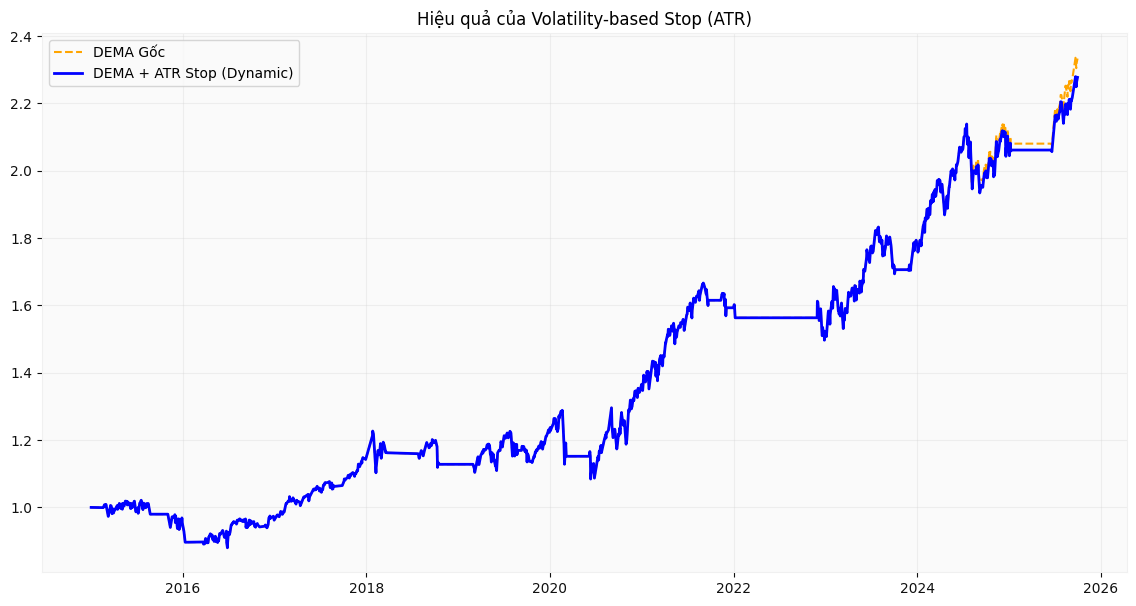

In [32]:
# --- 1. HÀM TÍNH DEMA ---
def calculate_dema(series, span):
    ema1 = series.ewm(span=span, adjust=False).mean()
    ema2 = ema1.ewm(span=span, adjust=False).mean()
    return 2 * ema1 - ema2

# --- 2. HÀM TÍNH ATR (Chỉ báo đo biến động) ---
def calculate_atr(df, window=14):
    data = df.copy()
    high = data['high']
    low = data['low']
    close = data['close']

    # Tính True Range (TR)
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))

    # Lấy giá trị lớn nhất trong 3 cái (Max True Range)
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # Tính ATR (SMA của TR)
    atr = tr.rolling(window=window).mean()
    return atr

# --- 3. CHIẾN LƯỢC: DEMA + ATR TRAILING STOP ---
def strategy_dema_atr_stop(df, atr_multiplier=3.0):
    """
    atr_multiplier: Hệ số k.
    Thường dùng 2.5 đến 3.5. Số càng to thì Stoploss càng lỏng (giữ lệnh lâu).
    """
    data = df.copy()

    # A. Tính Chỉ báo
    data['DEMA_S'] = calculate_dema(data['close'], span=50)
    data['DEMA_L'] = calculate_dema(data['close'], span=200)
    data['ATR'] = calculate_atr(data, window=14)

    # B. Logic Vòng lặp
    signals = np.zeros(len(data))
    position = 0          # 0: Tiền mặt, 1: Cổ phiếu
    highest_price = 0     # Đỉnh cao nhất kể từ khi mua
    stop_price = 0        # Giá cắt lỗ hiện tại

    price_arr = data['close'].values
    dema_s_arr = data['DEMA_S'].values
    dema_l_arr = data['DEMA_L'].values
    atr_arr = data['ATR'].values

    for i in range(1, len(data)):
        # Nếu chưa có ATR (mấy ngày đầu bị NaN), bỏ qua
        if np.isnan(atr_arr[i]):
            continue

        # --- TRƯỜNG HỢP 1: ĐANG CẦM TIỀN (Tìm điểm mua) ---
        if position == 0:
            # Logic vào lệnh: DEMA Ngắn cắt lên DEMA Dài
            if dema_s_arr[i] > dema_l_arr[i]:
                position = 1
                highest_price = price_arr[i] # Ghi nhận giá mua là đỉnh tạm thời
                # Đặt Stoploss ban đầu = Giá - (k * ATR)
                stop_price = highest_price - (atr_multiplier * atr_arr[i])

        # --- TRƯỜNG HỢP 2: ĐANG CẦM CỔ  ---
        elif position == 1:
            # 1. Cập nhật đỉnh mới (High Water Mark)
            if price_arr[i] > highest_price:
                highest_price = price_arr[i]
                # Kéo Stoploss lên theo đỉnh (Trailing)
                # Công thức: Stoploss Mới = Đỉnh Mới - (k * ATR hiện tại)
                new_stop = highest_price - (atr_multiplier * atr_arr[i])

                # Quan trọng: Stoploss chỉ được TĂNG, không được GIẢM
                if new_stop > stop_price:
                    stop_price = new_stop

            # 2. Kiểm tra điều kiện BÁN

            # Điều kiện A: Giá đóng cửa thủng Stoploss (Chốt lời/Cắt lỗ động)
            if price_arr[i] < stop_price:
                position = 0

            # Điều kiện B: DEMA cắt xuống (Gãy xu hướng )
            elif dema_s_arr[i] < dema_l_arr[i]:
                position = 0

        signals[i] = position

    data['Signal'] = signals

    # C. Tính Hiệu suất
    data['Market_Ret'] = data['close'].pct_change()
    data['Strategy_Ret'] = data['Signal'].shift(1) * data['Market_Ret']
    data['Cum_Strategy'] = (1 + data['Strategy_Ret'].fillna(0)).cumprod()

    # Tính Drawdown
    peak = data['Cum_Strategy'].cummax()
    data['Drawdown'] = (data['Cum_Strategy'] - peak) / peak

    # Stop Price chỉ có ý nghĩa khi Signal = 1
    return data

# --- 4. CHẠY VÀ SO SÁNH ---
try:
    # Chạy chiến lược ATR Stop (Hệ số k=3 )
    results_atr = strategy_dema_atr_stop(df, atr_multiplier=3.0)

    # Chạy chiến lược DEMA Gốc (để so sánh)
    # Lưu ý: Cần hàm strategy_dema cũ của bạn
    results_basic = strategy_dema(df)

    # Lấy chỉ số
    ret_atr = results_atr['Cum_Strategy'].iloc[-1] - 1
    mdd_atr = results_atr['Drawdown'].min()

    ret_basic = results_basic['Cumulative_Strategy'].iloc[-1] - 1
    mdd_basic = results_basic['Drawdown'].min()

    print(f"{'Chiến lược':<30} | {'Lợi nhuận':<15} | {'Max Drawdown':<15}")
    print("-" * 65)
    print(f"{'DEMA Gốc ':<30} | {ret_basic:.2%} {'':<8} | {mdd_basic:.2%}")
    print(f"{'DEMA + ATR Trailing Stop':<30} | {ret_atr:.2%} {'':<8} | {mdd_atr:.2%}")

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 7))
    plt.plot(results_basic.index, results_basic['Cumulative_Strategy'], label='DEMA Gốc', color='orange', linestyle='--')
    plt.plot(results_atr.index, results_atr['Cum_Strategy'], label='DEMA + ATR Stop (Dynamic)', color='blue', linewidth=2)
    plt.title('Hiệu quả của Volatility-based Stop (ATR)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

except Exception as e:
    print("Lỗi:", e)

Cách tinh chỉnh hệ số atr_multiplier (k):
Trong hàm strategy_dema_atr_stop(df, atr_multiplier=3.0):

- k = 3.0 (Mặc định): Dành cho đầu tư trung hạn. Đủ rộng để không bị quét bởi nhiễu hàng ngày, nhưng đủ chặt để khóa lợi nhuận khi trend gãy.

- k = 2.0 (Chặt): Dành cho thị trường đang rất biến động hoặc bạn muốn "ăn non" (chốt sớm). Lợi nhuận có thể cao hơn nhưng dễ bị "văng" khỏi trend sớm.

- k = 4.0 (Lỏng): Dành cho các siêu cổ phiếu (như Tesla, NVDA) biến động cực mạnh. Giúp bạn lì đòn hơn để ăn trọn con sóng lớn.

In [ ]:
! git add .
! git commit -m "Update MA"
! git push
